# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import CountryCapital, FriendEnemy, WorldLeaders

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
SEED = 0
# DATASET_NAME = "CountryCapital"
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=450,
#     max_entities=90,
#     cap_per_type=True,
#     raw_country_capitals_path="data/CountryCapital/real-fake-historical-fictional-famousfictional-country-capital.csv",
# )
# DATASET_NAME = "FriendEnemy"
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=15,
#     max_entities=5,
#     cap_per_type=False,
#     raw_data_path="data/FriendEnemy/raw-friend-enemy.csv",
# )
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=657,
#     max_entities=73,
#     cap_per_type=False,
#     raw_data_path="data/FriendEnemy/raw-friend-enemy.csv",
# )
DATASET_NAME = "WorldLeaders"
DATASET_KWARGS_IDENTIFIABLE = dict(
    max_contexts=450,
    max_entities=90,
    cap_per_type=False,
    raw_data_path="data/WorldLeaders/world-leaders-2001-to-2021.csv",
    ablate_out_relevant_contexts=False,
)
LOG_DATASETS = True


# Model parameters
# MODEL_ID = "EleutherAI/pythia-70m-deduped"
# LOAD_IN_8BIT = False
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
BATCH_SZ = 16

# Evaluation switches
COMPUTE_CMI = True
COMPUTE_KL = True
COMPUTE_GOOD_BAD = True
COMPUTE_GOOD_BAD_ABS = True
COMPUTE_GOOD_BAD_P_GOOD_ONLY = True

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["friend-enemy", "analysis"]

In [4]:
# Paths
# Construct dataset and data ids
# dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)
data_id = f"{DATASET_NAME}"
data_id += (
    f"-mc{DATASET_KWARGS_IDENTIFIABLE['max_contexts']}"
    if "max_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_contexts"] is not None
    else ""
)
data_id += (
    f"-me{DATASET_KWARGS_IDENTIFIABLE['max_entities']}"
    if "max_entities" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_entities"] is not None
    else ""
)
data_id += (
    "-cappertype"
    if "cap_per_type" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["cap_per_type"]
    else ""
)
data_id += (
    "-ablate"
    if "ablate_out_relevant_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
    else ""
)

data_dir = os.path.join("data", DATASET_NAME, data_id, f"{SEED}")
input_dir = os.path.join(data_dir, "inputs")
entities_path = os.path.join(input_dir, "entities.json")
contexts_path = os.path.join(input_dir, "contexts.json")
queries_path = os.path.join(input_dir, "queries.json")
val_data_path = os.path.join(input_dir, "val.csv")
DATASET_KWARGS_IDENTIFIABLE = {
    **DATASET_KWARGS_IDENTIFIABLE,
    **dict(
        entities_path=entities_path,
        contexts_path=contexts_path,
        queries_path=queries_path,
    ),
}

# Construct model id
model_id = f"{MODEL_ID}"
model_id += "-8bit" if LOAD_IN_8BIT else ""
model_dir = os.path.join(data_dir, "models", model_id)

# Results path
results_dir = os.path.join(model_dir, "results")
val_results_path = os.path.join(results_dir, "val.csv")

print(f"Data dir: {data_dir}")
print(f"Model dir: {model_dir}")

Data dir: data/WorldLeaders/WorldLeaders-mc450-me90/0
Model dir: data/WorldLeaders/WorldLeaders-mc450-me90/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [5]:
# Analysis dir
analysis_dir = os.path.join(data_dir, "analysis")
print(f"Analysis dir: {analysis_dir}")

Analysis dir: data/WorldLeaders/WorldLeaders-mc450-me90/0/analysis


In [6]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

In [7]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'SEED': 0, 'DATASET_NAME': 'WorldLeaders', 'DATASET_KWARGS_IDENTIFIABLE': {'max_contexts': 450, 'max_entities': 90, 'cap_per_type': False, 'raw_data_path': 'data/WorldLeaders/world-leaders-2001-to-2021.csv', 'ablate_out_relevant_contexts': False, 'entities_path': 'data/WorldLeaders/WorldLeaders-mc450-me90/0/inputs/entities.json', 'contexts_path': 'data/WorldLeaders/WorldLeaders-mc450-me90/0/inputs/contexts.json', 'queries_path': 'data/WorldLeaders/WorldLeaders-mc450-me90/0/inputs/queries.json'}, 'LOG_DATASETS': True, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'BATCH_SZ': 16, 'COMPUTE_CMI': True, 'COMPUTE_KL': True, 'COMPUTE_GOOD_BAD': True, 'COMPUTE_GOOD_BAD_ABS': True, 'COMPUTE_GOOD_BAD_P_GOOD_ONLY': True, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['friend-enemy', 'analysis']}


### Load Data

In [10]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path, index_col=0, converters={"contexts": literal_eval}
)

In [11]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/WorldLeaders/WorldLeaders-mc450-me90/0/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2b1f4f9c0d00>.


### Analyze Data

In [12]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,contexts,susceptibility_score
0,capital_of,Q: What country is led by {}?\nA:,"('Evaristo Carvalho',)",[Hans-Adam II is the leader of Taiwan (Republi...,0.240882
1,capital_of,Q: What country is led by {}?\nA:,"('Vicente Fox',)",[Hans-Adam II is the leader of Taiwan (Republi...,0.097520
2,capital_of,Q: What country is led by {}?\nA:,"('Dalia Grybauskaitė',)",[Hans-Adam II is the leader of Taiwan (Republi...,0.093990
3,capital_of,Q: What country is led by {}?\nA:,"('Zine El Abidine Ben Ali',)",[Hans-Adam II is the leader of Taiwan (Republi...,0.065846
4,capital_of,Q: What country is led by {}?\nA:,"('Filip Vujanović',)",[Hans-Adam II is the leader of Taiwan (Republi...,0.180826


In [13]:
val_df_contexts_per_qe["entity"] = val_df_contexts_per_qe["entity"].apply(eval)
val_df_contexts_per_qe["entity"].value_counts()

(Elizabeth II,)            14
(Jakaya Kikwete,)           4
(Idriss Déby,)              4
(Toomas Hendrik Ilves,)     4
(Paul Biya,)                4
                           ..
(László Sólyom,)            2
(Ange-Félix Patassé,)       2
(Syed Sirajuddin,)          2
(Anerood Jugnauth,)         2
(Baron Waqa,)               2
Name: entity, Length: 79, dtype: int64

In [14]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Hans-Adam II is the leader of Taiwan (Republic of China).\n',
 'Elizabeth II is the leader of Mongolia.\n',
 'Presidency of Bosnia and Herzegovina is the leader of Netherlands.\n',
 'Presidency of Bosnia and Herzegovina is the leader of Belarus.\n',
 'Felipe VI is the leader of Greece.\n',
 'Recep Tayyip Erdoğan is the leader of Niger.\n',
 'Elizabeth II is the leader of Mexico.\n',
 'Elizabeth II is the leader of Hungary.\n',
 "Joko Widodo is the leader of North Korea (Democratic People's Republic of Korea).\n",
 'Norodom Sihamoni is the leader of Madagascar.\n']

In [15]:
sorted(val_df_contexts_per_qe.iloc[0]["contexts"])

['Albert II is the leader of Albania.\n',
 'Albert II is the leader of Armenia.\n',
 'Albert II is the leader of Belize.\n',
 'Albert II is the leader of Cyprus.\n',
 'Albert II is the leader of Dominican Republic.\n',
 'Albert II is the leader of Egypt.\n',
 'Albert II is the leader of Finland.\n',
 'Albert II is the leader of Gabon.\n',
 'Albert II is the leader of Haiti.\n',
 'Albert II is the leader of Indonesia.\n',
 'Albert II is the leader of Latvia.\n',
 'Albert II is the leader of Lesotho.\n',
 'Albert II is the leader of Malta.\n',
 'Albert II is the leader of Uzbekistan.\n',
 'Albert II is the leader of Vatican City.\n',
 'Albert II is the leader of Vatican City.\n',
 'Alexander Lukashenko is the leader of Albania.\n',
 'Alexander Lukashenko is the leader of Lithuania.\n',
 'Alexander Lukashenko is the leader of Maldives.\n',
 'Alexander Lukashenko is the leader of Marshall Islands.\n',
 'Alexander Lukashenko is the leader of Mauritius.\n',
 'Alexander Lukashenko is the lead

In [16]:
world_leaders_data = pd.read_csv(
    DATASET_KWARGS_IDENTIFIABLE["raw_data_path"],
    # os.path.join("data", DATASET_NAME, "real-fake-country-capital.csv"),
    index_col=0,
)
world_leaders_data["entity"] = [(l,) for l in world_leaders_data["leader"]]
world_leaders_data

,country,leader,continent,year,entity
0,Algeria,Abdelaziz Bouteflika,Africa,2001,"(Abdelaziz Bouteflika,)"
1,Angola,José Eduardo dos Santos,Africa,2001,"(José Eduardo dos Santos,)"
2,Benin,Mathieu Kérékou,Africa,2001,"(Mathieu Kérékou,)"
3,Botswana,Festus Mogae,Africa,2001,"(Festus Mogae,)"
4,Burkina Faso,Blaise Compaoré,Africa,2001,"(Blaise Compaoré,)"
...,...,...,...,...,...
1178,Suriname,Chan Santokhi,South America,2021,"(Chan Santokhi,)"
1179,Uruguay,Luis Lacalle Pou,South America,2021,"(Luis Lacalle Pou,)"
1180,Venezuela,Venezuela,South America,2021,"(Venezuela,)"
1181,Venezuela,Nicolás Maduro,South America,2021,"(Nicolás Maduro,)"


In [17]:
val_df_contexts_per_qe

,q_id,query_form,entity,contexts,susceptibility_score
0,capital_of,Q: What country is led by {}?\nA:,"(Evaristo Carvalho,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.240882
1,capital_of,Q: What country is led by {}?\nA:,"(Vicente Fox,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.097520
2,capital_of,Q: What country is led by {}?\nA:,"(Dalia Grybauskaitė,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.093990
3,capital_of,Q: What country is led by {}?\nA:,"(Zine El Abidine Ben Ali,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.065846
4,capital_of,Q: What country is led by {}?\nA:,"(Filip Vujanović,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.180826
...,...,...,...,...,...
175,capital_of,{} is the leader of,"(Henri,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.888798
176,capital_of,{} is the leader of,"(Elizabeth II,)",[Hans-Adam II is the leader of Taiwan (Republi...,1.111177
177,capital_of,{} is the leader of,"(Bujar Nishani,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.689121
178,capital_of,{} is the leader of,"(Jakaya Kikwete,)",[Hans-Adam II is the leader of Taiwan (Republi...,0.076380


In [18]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    world_leaders_data,
    # left_on=["ent1", "ent2"],
    # right_on=["ent1", "ent2"],
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "country",
        "susceptibility_score",
        "year",
        "continent",
    ]
]
val_df_per_qe

,q_id,query_form,entity,country,susceptibility_score,year,continent
0,capital_of,Q: What country is led by {}?\nA:,"(Evaristo Carvalho,)",São Tomé and Príncipe,0.240882,2017,Africa
1,capital_of,Q: What country is led by {}?\nA:,"(Evaristo Carvalho,)",São Tomé and Príncipe,0.240882,2021,Africa
2,capital_of,Q: What country is led by {}?\nA:,"(Vicente Fox,)",Mexico,0.097520,2001,North America
3,capital_of,Q: What country is led by {}?\nA:,"(Vicente Fox,)",Mexico,0.097520,2005,North America
4,capital_of,Q: What country is led by {}?\nA:,"(Dalia Grybauskaitė,)",Lithuania,0.093990,2013,Europe
...,...,...,...,...,...,...,...
1775,capital_of,{} is the leader of,"(Bujar Nishani,)",Albania,0.689121,2013,Europe
1776,capital_of,{} is the leader of,"(Bujar Nishani,)",Albania,0.689121,2017,Europe
1777,capital_of,{} is the leader of,"(Jakaya Kikwete,)",Tanzania,0.076380,2009,Africa
1778,capital_of,{} is the leader of,"(Jakaya Kikwete,)",Tanzania,0.076380,2013,Africa


In [19]:
query_forms = val_df_per_qe["query_form"].unique()
print(query_forms)
for qf in query_forms:
    print(
        val_df_per_qe[val_df_per_qe["query_form"] == qf].sort_values(
            by="susceptibility_score"
        )
    )

['Q: What country is led by {}?\nA:' '{} is the leader of']
           q_id                         query_form             entity  \
30   capital_of  Q: What country is led by {}?\nA:    (Hamid Karzai,)   
31   capital_of  Q: What country is led by {}?\nA:    (Hamid Karzai,)   
32   capital_of  Q: What country is led by {}?\nA:    (Hamid Karzai,)   
671  capital_of  Q: What country is led by {}?\nA:  (Dilma Rousseff,)   
427  capital_of  Q: What country is led by {}?\nA:   (Robert Mugabe,)   
..          ...                                ...                ...   
90   capital_of  Q: What country is led by {}?\nA:    (Elizabeth II,)   
98   capital_of  Q: What country is led by {}?\nA:    (Elizabeth II,)   
539  capital_of  Q: What country is led by {}?\nA:    (Elizabeth II,)   
885  capital_of  Q: What country is led by {}?\nA:   (Bujar Nishani,)   
886  capital_of  Q: What country is led by {}?\nA:   (Bujar Nishani,)   

              country  susceptibility_score  year      continen

In [20]:
df_qf = val_df_per_qe[val_df_per_qe["query_form"] == query_forms[-1]].sort_values(
    by="susceptibility_score"
)

for e, s in list(zip(df_qf["entity"].tolist(), df_qf["susceptibility_score"].tolist())):
    print(e, s)

('Dalia Grybauskaitė',) 0.0681687017429534
('Dalia Grybauskaitė',) 0.0681687017429534
('Hamid Karzai',) 0.0712231716727994
('Hamid Karzai',) 0.0712231716727994
('Hamid Karzai',) 0.0712231716727994
('John Magufuli',) 0.0745901267695875
('John Magufuli',) 0.0745901267695875
('Jakaya Kikwete',) 0.0763799364512501
('Jakaya Kikwete',) 0.0763799364512501
('Jakaya Kikwete',) 0.0763799364512501
('Jakaya Kikwete',) 0.0763799364512501
('Viktor Yanukovych',) 0.078708179108949
('Mahinda Rajapaksa',) 0.0892697388441217
('Mahinda Rajapaksa',) 0.0892697388441217
('Aleksandar Vučić',) 0.0901794858865182
('Zine El Abidine Ben Ali',) 0.0911822936695261
('Zine El Abidine Ben Ali',) 0.0911822936695261
('Zine El Abidine Ben Ali',) 0.0911822936695261
('Óscar Arias',) 0.0963100614238445
('Dilma Rousseff',) 0.0969321126470006
('Cyril Ramaphosa',) 0.0973317289242233
('Felipe VI',) 0.103089847362007
('Felipe VI',) 0.103089847362007
('Robert Mugabe',) 0.1047123280786297
('Robert Mugabe',) 0.1047123280786297
('Ro

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

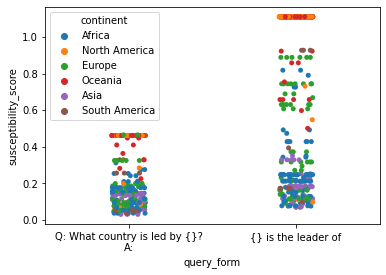

In [21]:
sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="continent",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

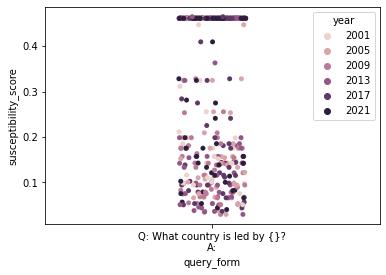

In [23]:
sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_form"] != query_forms[-1]],
    x="query_form",
    y="susceptibility_score",
    hue="year",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

In [ ]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="label",
    ax=ax,
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["type"].isin(
            [
                "sports",
                "politics",
                "movie",
            ]
        )
    ],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_type"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
fig

In [ ]:
val_df_contexts_per_qe["num_contexts_containing_entity"] = val_df_contexts_per_qe.apply(
    lambda x: sum(x["entity"][0] in c for c in x["contexts"]), axis=1
)

In [ ]:
fig, ax = plt.subplots()
df = val_df_contexts_per_qe[
    val_df_contexts_per_qe["query_form"] == val_df_per_qe["query_form"].unique()[0]
]
ax = sns.scatterplot(
    data=df,
    x="num_contexts_containing_entity",
    y="susceptibility_score",
)
ax.set_xlim(0, 30)
x = df["num_contexts_containing_entity"]
x = sm.add_constant(x)
y = df["susceptibility_score"]
ols_model = sm.OLS(y, x).fit()
ols_model.summary()

In [ ]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [ ]:
def print_top_k_next_token_probs(model, tokenizer, query, entity, context, k=50):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=context),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [ ]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_contexts_per_qe[
    val_df_contexts_per_qe["query_form"] == query_forms[1]
].sort_values(by="susceptibility_score")

In [ ]:
pp = pprint.PrettyPrinter()
row = (
    val_df_contexts_per_qe[val_df_contexts_per_qe["query_form"] == query_forms[0]]
    .sort_values(by="susceptibility_score")
    .iloc[3]
)
entity = row["entity"]
contexts = row["contexts"]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context=""))
print("CMI:", estimate_cmi(query, entity, contexts, model, tokenizer))

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(model, tokenizer, query, entity, context="", k=50)
print("\n\n")

for context in contexts:
    # for context in contexts[:5]:
    if entity[0] in context:
        print(f"*{format_query(query=query, entity=entity, context=context)}*")
        print_top_k_next_token_probs(model, tokenizer, query, entity, context, k=50)
        print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context=""),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

In [ ]:
wandb.finish()